In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd

In [4]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [14]:
engine = new_engine('mssql', 'LILLEHP\MSSQLSERVER11', 'AdventureWorks2022', integrated_security=True)
print(type(engine))

mssql://LILLEHP\MSSQLSERVER11/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server
<class 'sqlalchemy.engine.base.Engine'>


In [15]:
connection = engine.connect()
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [20]:
for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


In [55]:
for col in inspector.get_columns(table_name='Customer', schema='Sales'):
    print(col['name'])

CustomerID
PersonID
StoreID
TerritoryID
AccountNumber
rowguid
ModifiedDate


In [ ]:
#Count how many employees each department has, and how many technicians that works in production.

In [217]:
employeedep_SQL = """
SELECT 
    d.Name AS Department,
    COUNT(e.BusinessEntityID) AS Employees
FROM 
    HumanResources.Employee AS e
INNER JOIN 
    HumanResources.EmployeeDepartmentHistory AS edh ON e.BusinessEntityID = edh.BusinessEntityID
INNER JOIN 
    HumanResources.Department AS d ON edh.DepartmentID = d.DepartmentID
GROUP BY 
    d.Name
ORDER BY 
    Employees DESC;
"""

employeedep = pd.read_sql(sql=employeedep_SQL, con=connection)

technicians_SQL = """
SELECT 
    COUNT(e.BusinessEntityID) AS 'Technicians in production'
FROM 
    HumanResources.Employee AS e
INNER JOIN 
    HumanResources.EmployeeDepartmentHistory AS edh ON e.BusinessEntityID = edh.BusinessEntityID
INNER JOIN 
    HumanResources.Department AS d ON edh.DepartmentID = d.DepartmentID
WHERE 
    d.Name = 'Production'
    AND e.JobTitle LIKE '%Technician%'
    AND edh.EndDate is NULL;
"""

technicians = pd.read_sql(sql=technicians_SQL, con=connection)

result_df = pd.concat([employeedep, technicians], axis=1, keys=['All employees', 'Technicians'])
result_df.head()

All employees                         Technicians
             Department Employees Technicians in production
0            Production       180                     157.0
1                 Sales        18                       NaN
2            Purchasing        13                       NaN
3               Finance        11                       NaN
4  Information Services        10                       NaN

In [ ]:
#View the orders that didn't recieved all products

In [225]:
view_sql = """
SELECT *
FROM Purchasing.PurchaseOrderDetail
WHERE OrderQty > ReceivedQty
"""

view = pd.read_sql(sql=view_sql, con=connection)
view.head(10)

,PurchaseOrderID,PurchaseOrderDetailID,DueDate,OrderQty,ProductID,UnitPrice,LineTotal,ReceivedQty,RejectedQty,StockedQty,ModifiedDate
0,1,1,2011-04-30,4,1,50.2600,201.0400,3.0,0.0,3.0,2011-04-23
1,4,5,2011-04-30,3,4,57.0255,171.0765,2.0,1.0,1.0,2011-04-23
2,6,7,2011-05-14,550,513,26.5965,14628.0750,468.0,0.0,468.0,2011-05-07
3,25,59,2011-12-29,550,508,29.2845,16106.4750,523.0,0.0,523.0,2011-12-22
4,36,85,2012-01-30,550,908,21.0945,11601.9750,468.0,0.0,468.0,2012-01-23
5,45,102,2012-01-30,550,511,27.8670,15326.8500,523.0,0.0,523.0,2012-01-23
6,46,103,2012-01-30,550,527,6.7515,3713.3250,468.0,0.0,468.0,2012-01-23
7,65,148,2012-02-07,550,932,39.2385,21581.1750,523.0,0.0,523.0,2012-01-31
8,75,170,2012-02-23,550,318,36.0990,19854.4500,523.0,0.0,523.0,2012-02-16
9,76,172,2012-02-23,550,928,32.2455,17735.0250,468.0,0.0,468.0,2012-02-16


In [ ]:
#Gender of the employees

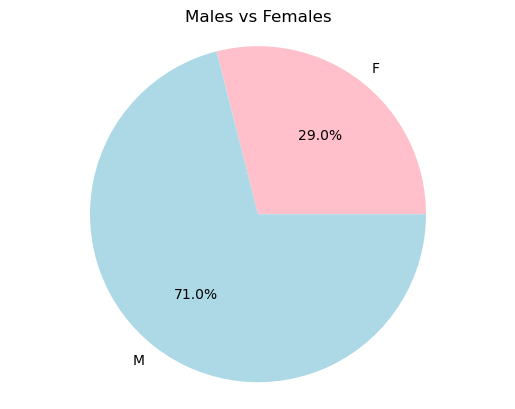

In [230]:
import matplotlib.pyplot as plt
gender_count_sql = """
SELECT Gender, COUNT(*) AS Count
FROM HumanResources.Employee
GROUP BY Gender;
"""

gender_count = pd.read_sql(sql=gender_count_sql, con=connection)
gender_count.head()

plt.pie(gender_count['Count'], labels=gender_count['Gender'], autopct='%1.1f%%', colors=['pink', 'lightblue'])
plt.axis('equal')
plt.title('Males vs Females')
plt.show()

In [ ]:
#The highest salary

In [98]:
salary_sql = """
SELECT 
    a.BusinessEntityID,
    e.Gender,
    e.OrganizationLevel,
    a.Rate,
    a.PayFrequency
FROM HumanResources.EmployeePayHistory AS a
JOIN HumanResources.Employee AS e ON a.BusinessEntityID = e.BusinessEntityID
ORDER BY (a.Rate) DESC;
"""
salary = pd.read_sql(sql=salary_sql, con=connection)
salary.head(10)

,BusinessEntityID,Gender,OrganizationLevel,Rate,PayFrequency
0,1,M,NaN,125.5000,2
1,25,M,1.0,84.1346,2
2,273,M,1.0,72.1154,2
3,2,F,1.0,63.4615,2
4,234,F,1.0,60.0962,2
5,263,F,1.0,50.4808,2
6,7,M,3.0,50.4808,2
7,234,F,1.0,48.5577,2
8,285,M,2.0,48.1010,2
9,274,M,2.0,48.1010,2


In [ ]:
#Highest salary at level 1

In [288]:
salaryHead_sql = """
SELECT 
    a.BusinessEntityID,
    e.Gender,
    e.OrganizationLevel,
    a.Rate,
    a.PayFrequency
FROM HumanResources.EmployeePayHistory AS a
JOIN HumanResources.Employee AS e ON a.BusinessEntityID = e.BusinessEntityID
WHERE e.OrganizationLevel = 1
ORDER BY (a.Rate) DESC;
"""
salaryHead = pd.read_sql(sql=salaryHead_sql, con=connection)
salaryHead.head()

,BusinessEntityID,Gender,OrganizationLevel,Rate,PayFrequency
0,25,M,1,84.1346,2
1,273,M,1,72.1154,2
2,2,F,1,63.4615,2
3,234,F,1,60.0962,2
4,263,F,1,50.4808,2


In [ ]:
#Most sickhours

In [132]:
sickdays_sql ="""
SELECT 
    e.JobTitle, 
    p.LastName, 
    e.VacationHours,
    e.SickLeaveHours

FROM HumanResources.Employee AS e
INNER JOIN Person.Person AS p
    ON e.BusinessEntityID = p.BusinessEntityID
ORDER BY SickLeaveHours DESC;
"""
sickdays = sickdays = pd.read_sql(sql=sickdays_sql, con=connection)
sickdays.head(10)

,JobTitle,LastName,VacationHours,SickLeaveHours
0,Senior Tool Designer,Walters,48,80
1,Chief Executive Officer,Sánchez,99,69
2,Production Technician - WC10,Stadick,99,69
3,Production Technician - WC10,Vande Velde,98,69
4,Production Technician - WC50,Patten,98,69
5,Production Technician - WC50,Niswonger,99,69
6,Stocker,Ralls,98,69
7,Stocker,Eaton,97,68
8,Production Technician - WC50,Moschell,96,68
9,Production Technician - WC50,Krapauskas,97,68


In [ ]:
#Lowest vacationhours

In [138]:
vacationdays_sql ="""
SELECT 
    e.JobTitle, 
    p.LastName, 
    e.SickLeaveHours,
    e.VacationHours

FROM HumanResources.Employee AS e
INNER JOIN Person.Person AS p
    ON e.BusinessEntityID = p.BusinessEntityID
ORDER BY VacationHours;
"""
vacationdays = pd.read_sql(sql=vacationdays_sql, con=connection)
vacationdays.head(10)

,JobTitle,LastName,SickLeaveHours,VacationHours
0,Production Technician - WC20,Ting,20,0
1,Production Technician - WC50,Samant,20,0
2,Chief Financial Officer,Norman,20,0
3,Vice President of Engineering,Duffy,20,1
4,Production Technician - WC50,Scardelis,20,1
5,Production Technician - WC20,Su,20,1
6,Production Technician - WC20,Sunkammurali,21,2
7,Production Technician - WC50,Yu,21,2
8,Engineering Manager,Tamburello,21,2
9,Senior Design Engineer,Sullivan,21,3


In [ ]:
#12 months sales comparison

In [147]:
salesyear_sql ="""
SELECT 
    TerritoryName, 
    BusinessEntityID, 
    FORMAT(SalesYTD, 'N2') AS SalesYTD,   
    FORMAT(LAG(SalesYTD, 1, 0) OVER (PARTITION BY TerritoryName ORDER BY SalesYTD DESC), 'N2') AS SalesLastYear
FROM Sales.vSalesPerson  
WHERE TerritoryGroup IN ('North America', 'Europe', 'Pacific')   
ORDER BY SalesLastYear DESC;
"""
salesyear = pd.read_sql(sql=salesyear_sql, con=connection)
salesyear.head()

,TerritoryName,BusinessEntityID,SalesYTD,SalesLastYear
0,Southwest,281,"2,458,535.62","4,251,368.55"
1,Canada,278,"1,453,719.47","2,604,540.72"
2,Northwest,283,"1,573,012.94","1,576,562.20"
3,Northwest,280,"1,352,577.13","1,573,012.94"
4,Southeast,279,"2,315,185.61",0.00


In [ ]:
#Territory with highest sales

In [151]:
bestsales_sql ="""
SELECT 
    TerritoryName, 
    BusinessEntityID, 
    FORMAT(SalesYTD, 'N2') AS SalesYTD
    
FROM Sales.vSalesPerson  
WHERE TerritoryGroup IN ('North America', 'Europe', 'Pacific')   
ORDER BY SalesYTD DESC;
"""
bestsales = pd.read_sql(sql=bestsales_sql, con=connection)
bestsales.head()

,TerritoryName,BusinessEntityID,SalesYTD
0,Southwest,276,"4,251,368.55"
1,United Kingdom,289,"4,116,871.23"
2,Northeast,275,"3,763,178.18"
3,Central,277,"3,189,418.37"
4,France,290,"3,121,616.32"


In [ ]:
#Orders that are delayed

In [164]:
deliverytime_SQL="""
SELECT 
    SalesOrderID,
    OrderDate,
    DueDate,
    ShipDate
FROM Sales.SalesOrderHeader
WHERE ShipDate > DueDate;
"""
deliverytime = pd.read_sql(sql=deliverytime_SQL, con=connection)
deliverytime.head()

,SalesOrderID,OrderDate,DueDate,ShipDate


In [ ]:
#The sales people with the lowest and highest sales (order by new format didn't work correctly)

In [187]:
lowestsales_SQL = """
SELECT 
    p.FirstName,
    p.LastName,
    s.SalesYTD,
    FORMAT(s.SalesYTD, 'N2') AS Sales,
    a.City 
      
FROM Sales.SalesPerson AS s   
INNER JOIN Person.Person AS p   
    ON s.BusinessEntityID = p.BusinessEntityID  
INNER JOIN Person.Address AS a   
    ON a.AddressID = p.BusinessEntityID  
ORDER BY SalesYTD ASC; 
"""
lowestsales = pd.read_sql(sql=lowestsales_SQL, con=connection)

highestsales_SQL = """
SELECT 
    p.FirstName,
    p.LastName,
    s.SalesYTD,
    FORMAT(s.SalesYTD, 'N2') AS Sales,
    a.City 
      
FROM Sales.SalesPerson AS s   
INNER JOIN Person.Person AS p   
    ON s.BusinessEntityID = p.BusinessEntityID  
INNER JOIN Person.Address AS a   
    ON a.AddressID = p.BusinessEntityID  
ORDER BY SalesYTD DESC; 
"""
highestsales = pd.read_sql(sql=highestsales_SQL, con=connection)

result_df = pd.concat([lowestsales, highestsales], axis=1, keys=['Lowest Sales', 'Highest Sales'])
result_df.head(5)

Lowest Sales                                                      \
     FirstName      LastName      SalesYTD         Sales      City   
0         Syed         Abbas  1.725245e+05    172,524.45    Renton   
1          Amy       Alberts  5.199059e+05    519,905.93    Renton   
2      Stephen         Jiang  5.596976e+05    559,697.56  Issaquah   
3       Pamela  Ansman-Wolfe  1.352577e+06  1,352,577.13  Issaquah   
4         Lynn      Tsoflias  1.421811e+06  1,421,810.92    Renton   

  Highest Sales                                                           
      FirstName           LastName      SalesYTD         Sales      City  
0         Linda           Mitchell  4.251369e+06  4,251,368.55  Issaquah  
1           Jae                Pak  4.116871e+06  4,116,871.23    Renton  
2       Michael             Blythe  3.763178e+06  3,763,178.18  Issaquah  
3       Jillian             Carson  3.189418e+06  3,189,418.37  Issaquah  
4        Ranjit  Varkey Chudukatil  3.121616e+06  3,121,616.32    Renton

In [ ]:
#Best and worst selling products, and it's stocklevels

In [191]:
bestselling_SQL = """
SELECT 
    p.ProductID,
    p.Name AS ProductName,
    p.Color,
    p.Size,
    SUM(sod.OrderQty) AS TotalQuantitySold,
    pi.Quantity AS StockLevel
FROM 
    Production.Product AS p
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON p.ProductID = sod.ProductID
LEFT JOIN 
    Production.ProductInventory AS pi ON p.ProductID = pi.ProductID
GROUP BY 
    p.ProductID, p.Name, p.Color, p.Size, pi.Quantity
ORDER BY 
    TotalQuantitySold DESC;
"""

bestselling = pd.read_sql(sql=bestselling_SQL, con=connection)

worstselling_SQL = """
SELECT 
    p.ProductID,
    p.Name AS ProductName,
    p.Color,
    p.Size,
    SUM(sod.OrderQty) AS TotalQuantitySold,
    pi.Quantity AS StockLevel
FROM 
    Production.Product AS p
INNER JOIN 
    Sales.SalesOrderDetail AS sod ON p.ProductID = sod.ProductID
LEFT JOIN 
    Production.ProductInventory AS pi ON p.ProductID = pi.ProductID
GROUP BY 
    p.ProductID, p.Name, p.Color, p.Size, pi.Quantity
ORDER BY 
    TotalQuantitySold ASC;
"""
worstselling = pd.read_sql(sql=worstselling_SQL, con=connection)

result_df = pd.concat([bestselling, worstselling], axis=1, keys=['Best Products ', 'Worst Products'])
result_df.head(10)

Best Products                                                  \
       ProductID                      ProductName   Color  Size   
0            712                     AWC Logo Cap   Multi  None   
1            870            Water Bottle - 30 oz.    None  None   
2            711           Sport-100 Helmet, Blue    Blue  None   
3            715       Long-Sleeve Logo Jersey, L   Multi     L   
4            708          Sport-100 Helmet, Black   Black  None   
5            707            Sport-100 Helmet, Red     Red  None   
6            864                  Classic Vest, S    Blue     S   
7            873              Patch Kit/8 Patches    None  None   
8            884  Short-Sleeve Classic Jersey, XL  Yellow    XL   
9            714       Long-Sleeve Logo Jersey, M   Multi     M   

                               Worst Products  \
  TotalQuantitySold StockLevel      ProductID   
0              8311      288.0            897   
1              6815      252.0            942   
2              6743      216.0            942   
3              6592      216.0            942   
4              6532      324.0            942   
5              6266      288.0            942   
6              4247      180.0            942   
7              3865      180.0            943   
8              3864       72.0            943   
9              3636      180.0            943   

                                                                               
                        ProductName   Color Size TotalQuantitySold StockLevel  
0       LL Touring Frame - Blue, 58    Blue   58                 4        NaN  
1  ML Mountain Frame-W - Silver, 38  Silver   38                 7      120.0  
2  ML Mountain Frame-W - Silver, 38  Silver   38                 7      160.0  
3  ML Mountain Frame-W - Silver, 38  Silver   38                 7      158.0  
4  ML Mountain Frame-W - Silver, 38  Silver   38                 7      147.0  
5  ML Mountain Frame-W - Silver, 38  Silver   38                 7      136.0  
6  ML Mountain Frame-W - Silver, 38  Silver   38                 7      105.0  
7     LL Mountain Frame - Black, 40   Black   40                 8      129.0  
8     LL Mountain Frame - Black, 40   Black   40                 8       88.0  
9     LL Mountain Frame - Black, 40   Black   40                 8      140.0

In [ ]:
#Products that needs to be ordered

In [195]:
stocklevel_SQL = """
SELECT 
    p.ProductID,
    p.Name AS ProductName,
    p.Color,
    p.Size,
    pi.Quantity AS CurrentStock,
    p.SafetyStockLevel AS WantedStock
FROM 
    Production.Product AS p
INNER JOIN 
    Production.ProductInventory AS pi ON p.ProductID = pi.ProductID
WHERE 
    pi.Quantity < p.SafetyStockLevel
ORDER BY CurrentStock ASC;
"""

stocklevel = pd.read_sql(sql=stocklevel_SQL, con=connection)
stocklevel.head(20)


,ProductID,ProductName,Color,Size,CurrentStock,WantedStock
0,853,"Women's Tights, M",Black,M,0,4
1,859,"Half-Finger Gloves, M",Black,M,0,4
2,876,Hitch Rack - 4-Bike,None,None,0,4
3,882,"Short-Sleeve Classic Jersey, M",Yellow,M,0,4
4,494,Paint - Silver,None,None,4,60
5,494,Paint - Silver,None,None,12,60
6,492,Paint - Black,None,None,14,60
7,492,Paint - Black,None,None,16,60
8,492,Paint - Black,None,None,17,60
9,493,Paint - Red,None,None,24,60


In [ ]:
#Highest and lowest revenues

In [242]:
best_revenues_sql = """
SELECT TOP (5)
    p.ProductID,
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID, p.Name
ORDER BY 
    TotalRevenue DESC;
"""

worst_revenues_sql = """
SELECT TOP(5)
    p.ProductID,
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID, p.Name
ORDER BY 
    TotalRevenue ASC;
"""

best_revenues_df = pd.read_sql(sql=best_revenues_sql, con=connection)
worst_revenues_df = pd.read_sql(sql=worst_revenues_sql, con=connection)

print("Best Revenues:")
print(best_revenues_df)
print()
print("Worst Revenues:")
print(worst_revenues_df)

Best Revenues:
   ProductID              ProductName  TotalRevenue
0        782   Mountain-200 Black, 38  4.400593e+06
1        783   Mountain-200 Black, 42  4.009495e+06
2        779  Mountain-200 Silver, 38  3.693678e+06
3        780  Mountain-200 Silver, 42  3.438479e+06
4        781  Mountain-200 Silver, 46  3.434257e+06

Worst Revenues:
   ProductID                    ProductName  TotalRevenue
0        911            LL Road Seat/Saddle       162.720
1        710         Mountain Bike Socks, L       513.000
2        897    LL Touring Frame - Blue, 58       800.208
3        943  LL Mountain Frame - Black, 40      1198.992
4        914         LL Touring Seat/Saddle      1480.752


In [ ]:
#Products with the highest and lowest margins

In [264]:
best_margins_sql = """
SELECT TOP(5)
    p.ProductID,
    p.Name AS ProductName,
    AVG(p.StandardCost) AS AveragePurchasePrice,
    AVG(sod.UnitPrice) AS AverageSellingPrice,
    (AVG(sod.UnitPrice) - AVG(p.StandardCost)) / NULLIF(AVG(p.StandardCost), 0) * 100 AS ProfitMargin
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID, p.Name
HAVING 
    COUNT(sod.SalesOrderID) > 0
ORDER BY 
    ProfitMargin DESC;
"""

worst_margins_sql = """
SELECT TOP(5)
    p.ProductID,
    p.Name AS ProductName,
    AVG(p.StandardCost) AS AveragePurchasePrice,
    AVG(sod.UnitPrice) AS AverageSellingPrice,
    (AVG(sod.UnitPrice) - AVG(p.StandardCost)) / NULLIF(AVG(p.StandardCost), 0) * 100 AS ProfitMargin
FROM 
    Sales.SalesOrderDetail AS sod
INNER JOIN 
    Production.Product AS p ON sod.ProductID = p.ProductID
GROUP BY 
    p.ProductID, p.Name
HAVING 
    COUNT(sod.SalesOrderID) > 0
ORDER BY 
    ProfitMargin ASC;
"""

best_margins_df = pd.read_sql(sql=top5_best_margins_sql, con=connection)
worst_margins_df = pd.read_sql(sql=top5_worst_margins_sql, con=connection)

print("\nProducts with the Best Margins:")
print(best_margins_df)
print()
print("\nProducts with the Worst Margins:")
print(worst_margins_df)



Products with the Best Margins:
   ProductID             ProductName  AveragePurchasePrice  \
0        878   Fender Set - Mountain                8.2205   
1        879  All-Purpose Bike Stand               59.4660   
2        922          Road Tire Tube                1.4923   
3        928        LL Mountain Tire                9.3463   
4        931            LL Road Tire                8.0373   

   AverageSellingPrice  ProfitMargin  
0                21.98        167.38  
1               159.00        167.37  
2                 3.99        167.37  
3                24.99        167.37  
4                21.49        167.37  


Products with the Worst Margins:
   ProductID                   ProductName  AveragePurchasePrice  \
0        715    Long-Sleeve Logo Jersey, L               38.4923   
1        722     LL Road Frame - Black, 58              204.6251   
2        738     LL Road Frame - Black, 52              204.6251   
3        736     LL Road Frame - Black, 44           

In [ ]:
#Averages price of products in "Bike" category.

In [283]:
bikes_SQL = """
SELECT 
    pc.Name AS Category,
    AVG(sod.UnitPrice) AS Averagesales
FROM 
    Sales.SalesOrderDetail sod
    INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
    INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE 
    pc.Name = 'Bikes'
GROUP BY 
    pc.Name;
"""
bikes = pd.read_sql(sql=bikes_SQL, con=connection)
bikes.head()

,Category,Averagesales
0,Bikes,1254.6615


In [ ]:
#With 95% confidence interval, the average price is between 1246,27 and 1263 USD.

In [286]:
confidence_SQL = """
WITH BikeSales AS (
    SELECT 
        sod.UnitPrice
    FROM 
        Sales.SalesOrderDetail sod
        INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
        INNER JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
        INNER JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
    WHERE 
        pc.Name = 'Bikes'
)

SELECT
    AVG(UnitPrice) AS AverageBikePrice,
    COUNT(UnitPrice) AS NumberOfSales,
    AVG(UnitPrice) - 1.96 * (STDEV(UnitPrice) / SQRT(COUNT(UnitPrice))) AS LowerCI,
    AVG(UnitPrice) + 1.96 * (STDEV(UnitPrice) / SQRT(COUNT(UnitPrice))) AS UpperCI
FROM 
    BikeSales;
"""
confidence_df = pd.read_sql_query(confidence_SQL, connection)
print(confidence_df)

   AverageBikePrice  NumberOfSales      LowerCI      UpperCI
0         1254.6615          40031  1246.266722  1263.056278
